# Estimate time series parameters using pseudo batch transformed data
This tutorial will walk through how to estimate a series for the rates and yields from a fed-batch fermentation. This can be useful to detect changes in the phenotype during the fed-batch process. We will work with simulated data, thus the true parameters will be known.

## Initialise session and loading data

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os

from pseudobatch import pseudobatch_transform_pandas, reverse_pseudobatch_transform
from pseudobatch.datasets import load_product_inhibited_fedbatch

In [3]:
fedbatch_df = load_product_inhibited_fedbatch()

Most often we are not interested in the mass of substrate in the medium, but rather we are interested in the accumulated consumed substrate at any given timepoint. We will calculate this before moving on.

In [4]:
def consumed_substrate(concentration_in_feed, accumulated_feed_volume, measured_substrate_mass, initial_substrate_mass):
    return initial_substrate_mass + accumulated_feed_volume * concentration_in_feed - measured_substrate_mass

glucose_in_feed = fedbatch_df.s_f.iloc[0] # 100 g/L, substrate (glucose) concentration in feed is store in the dataframe 

fedbatch_df['m_Glucose_consumed'] = consumed_substrate(
    concentration_in_feed=glucose_in_feed,
    accumulated_feed_volume=fedbatch_df['v_Feed_accum'],
    measured_substrate_mass=fedbatch_df['m_Glucose'],
    initial_substrate_mass=0
)

To make a more realistic example, we will assume that we only have measurements at the sampling time points. Therefore we create a dataframe which contains these measurement data only.

In [5]:
fedbatch_df_measurement = fedbatch_df.query("sample_volume > 0").copy().reset_index(drop=True)

### Overview of the simulation
First let's have a look at the simulated data. The first 8 columns stores the parameters used for the simulation. Then comes the simulated data. Columns starting with m_, c_, and v_ describes mass', concentrations and volumes, respectively.

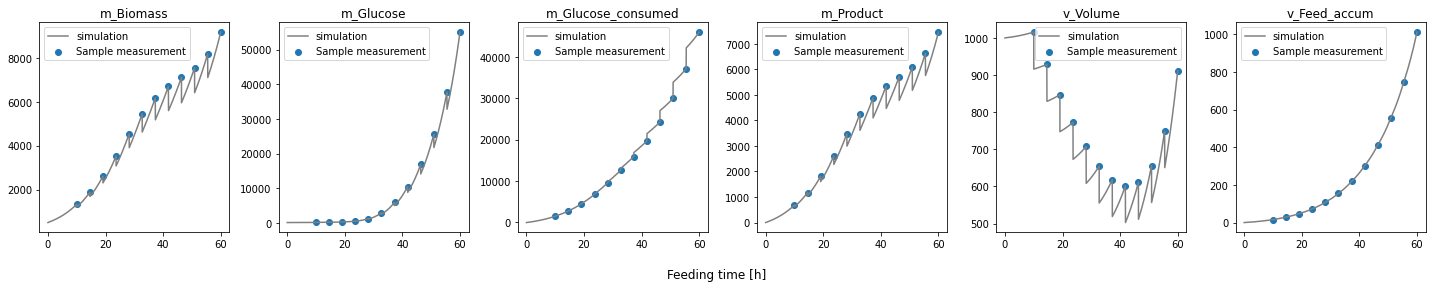

In [6]:
plot_columns = ["m_Biomass", "m_Glucose", "m_Glucose_consumed", "m_Product", "v_Volume", "v_Feed_accum"]

fig, axes = plt.subplots(nrows = 1, ncols = len(plot_columns), figsize=(20, 4))
for ax, column in zip(axes.ravel(), plot_columns):
    ax.plot(fedbatch_df["timestamp"], fedbatch_df[column], label="simulation", color="grey")
    ax.scatter(fedbatch_df_measurement["timestamp"], fedbatch_df_measurement[column], label="Sample measurement")
    ax.title.set_text(column)
    ax.legend()
fig.supxlabel("Feeding time [h]")
fig.tight_layout()

In [7]:
fedbatch_df_measurement[["c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo", "c_CO2_pseudo"]] = pseudobatch_transform_pandas(
    fedbatch_df_measurement,
    measured_concentration_colnames=["c_Biomass", "c_Glucose", "c_Product", "c_CO2"],
    reactor_volume_colname="v_Volume",
    accumulated_feed_colname="v_Feed_accum",
    sample_volume_colname="sample_volume",
    concentration_in_feed=[0, glucose_in_feed, 0, 0],
)

## Estimate the growth rate

We want to obtain estimates the growth rate as a function of time, i.e. to estimate $\mu(t)$. First, we will look at the mass balance for biomass. Assuming that the death rate is 0, the mass balance for the biomass is as follows:
$$
\frac{dX(t)}{dt} = \mu(t) * X(t)
$$
Where $X(t)$ is the biomass in grams, and $\mu$ is the specific growth rate. The goal is to find $\mu(t)$, therefore we can isolate $\mu(t)$ to get 
$$
\mu(t) = \frac{dX(t)}{dt} * X(t)^{-1}
$$ 

From the difference quotient of the biomass time series (the growth curve) and the biomass time series we can calculate the specific growth rate. Thus, we need to estimate $\frac{dX(t)}{dt}$. There are many methods that are capable of estimating the derivative of an underlying function (the true growth curve). Typically, these methods assume that the underlying function is continuous. From the plot above it easy to see that the true underlying growth curve of a sampled fed-batch fermentation is not continuous (See panel m_Biomass). Fortunately, the pseudo batch transformation transform the measurements in to a space where underlying growth curve is continuous and therefore the pseudo batch transformation enables the use of many methods to estimate rates as a function of time.

Here, we will show how to use finite differences to estimate the growth rate at each measurement time point.


In [8]:
def finite_difference_derivative(df: pd.DataFrame, x_colname: str, y_colname: str, log_transform_y: bool = False)->np.ndarray:
    x = df[x_colname].to_numpy()
    if log_transform_y:
        y = df[y_colname].transform(np.log).to_numpy()
    else:
        y = df[y_colname].to_numpy()
    return np.gradient(y, x)


mu_hat = finite_difference_derivative(fedbatch_df_measurement, "timestamp", "c_Biomass_pseudo", log_transform_y=False) / fedbatch_df_measurement.c_Biomass_pseudo

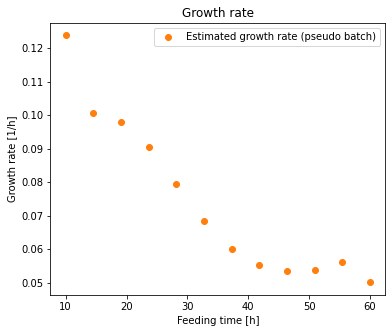

In [9]:
growth_rate_fig, growth_rate_ax = plt.subplots(figsize=(6, 5))
growth_rate_ax.scatter(fedbatch_df_measurement.timestamp, mu_hat, label="Estimated growth rate (pseudo batch)", color = "C1")
growth_rate_ax.set_title("Growth rate")
growth_rate_ax.set_xlabel("Feeding time [h]")
growth_rate_ax.set_ylabel("Growth rate [1/h]")
growth_rate_ax.legend()


From these specific growth rate time series we can see that the rate decreases during the fed-batch process. This hints that something may build up during the process and inhibiting the growth.
Because this data is simulated we know the true growth rate and we can compare this to the estimated growth rates.

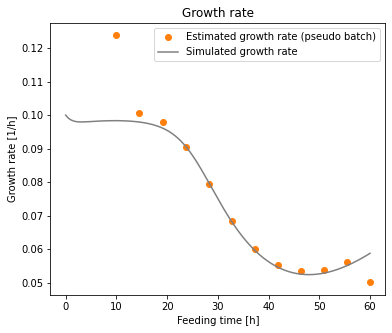

In [10]:
growth_rate_ax.plot(fedbatch_df.timestamp, fedbatch_df['mu_true'], label="Simulated growth rate", color = 'grey')[0]
growth_rate_ax.legend()
growth_rate_fig

We see that the estimate is in general close to true growth rate. but close to the boundaries the estimate gets worse. This is because the `np.gradient()` function use a rolling window af 5 data points (centered) to estimate the derivative, but at the boundaries there are not enough data points to fill the window. Therefore the quality of the estimate decreases. Remember that this is simulated data, and therefore we have the accurate measurements. That is not the case in the real world, here the measurements will be noisy, which will be reflected in the accuracy of the growth rate estimates.

## Estimate specific consumption or production rates
The mass balance of the non-biomass species is as follows:
$$
\frac{dm_i(t)}{dt} = r_i * X(t)
$$
Where $m_i(t)$ is the amount of the species $i$ in grams $r_i$ is the specific rate of species $i$, and $X(t)$ is the biomass in grams. The goal is to find $r_i(t)$, therefore we can isolate $r_i(t)$ to get 
$$
r_i(t) = \frac{dm_i(t)}{dt} * X(t)^{-1}
$$ 

Similarly to the growth rate, we can estimate $\frac{dm_i(t)}{dt}$ as the first order derivative of the time evolution of the species mass. Again using finite difference method we can estimate the rate as follows.

In [11]:
r_glucose_uptake = -1 * finite_difference_derivative(fedbatch_df_measurement, "timestamp", "c_Glucose_pseudo", log_transform_y=False) / fedbatch_df_measurement.c_Biomass_pseudo
r_product_production = finite_difference_derivative(fedbatch_df_measurement, "timestamp", "c_Product_pseudo", log_transform_y=False) / fedbatch_df_measurement.c_Biomass_pseudo
r_co2_production = finite_difference_derivative(fedbatch_df_measurement, "timestamp", "c_CO2_pseudo", log_transform_y=False) / fedbatch_df_measurement.c_Biomass_pseudo

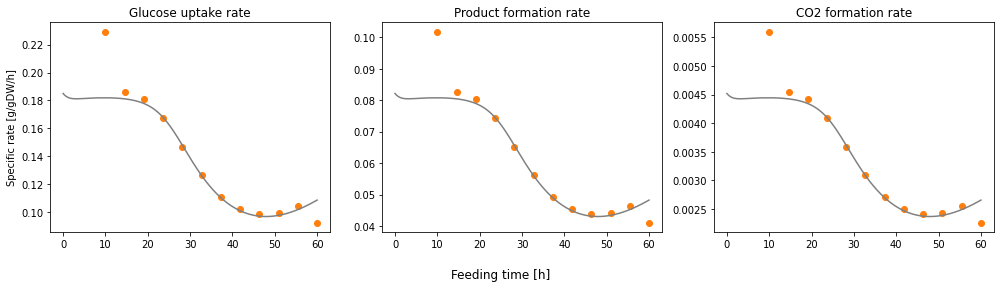

In [12]:
# Plot the results
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(14, 4))
axes[0].plot(fedbatch_df["timestamp"], fedbatch_df["mu_true"]*fedbatch_df['Yxs'], label="Simulated glucose uptake rate", color="grey")
axes[0].scatter(fedbatch_df_measurement["timestamp"], r_glucose_uptake, label="Estimated glucose uptake rate (pseudo batch)", color = "C1")
axes[0].set_title("Glucose uptake rate")
axes[1].plot(fedbatch_df["timestamp"], fedbatch_df["mu_true"]*fedbatch_df['Yxp'], label="Simulated product formation rate", color="grey")
axes[1].scatter(fedbatch_df_measurement["timestamp"], r_product_production, label="Estimated product formation rate (pseudo batch)", color = "C1")
axes[1].set_title("Product formation rate")
axes[2].plot(fedbatch_df["timestamp"], fedbatch_df["mu_true"]*fedbatch_df['Yxco2'], label="Simulated CO2 formation rate", color="grey")
axes[2].scatter(fedbatch_df_measurement["timestamp"], r_co2_production, label="Estimated CO2 formation rate (pseudo batch)", color = "C1")
axes[2].set_title("CO2 formation rate")

fig.supxlabel("Feeding time [h]")
axes[0].set_ylabel("Specific rate [g/gDW/h]")
fig.tight_layout()

Because this is simulated data the plot these plot are very similar only scaled differently, but it shows how estimate the rates as function of time based on pseudo batch transformed data.

## Estimate volumetric rates 

Sometimes one is interested in the volumetric rates. These can also be calculated from the pseudo batch transformed data, but it requires a bit extra care. Normally, we can calculate the volumetric rates using the following equation

$$
q_{species} = \frac{C_{species}(n) - C_{species}(0)}{t_n - t_0}
$$

where $n$ is the final time point. When we do this calculation with pseudo batch transformed data, we obtain the volumetric production rate in pseudo space.

$$
q^{\star}_{species} = \frac{C^{\star}_{species}(n) - C^{\star}_{species}(0)}{t_n - t_0}
$$

where the $^{\star}$ indicates that the number is in pseudo concentration space. To obtain the correct value we need to calculate the pseudo volumetric rates and then transform then into real concentration space using the the function `reverse_pseudo_batch_transform()`.

In [ ]:
reverse_pseudobatch_transform(
    meas['pseudo_Biomass_est_2nd_order'].to_numpy(),
    meas.v_Volume.to_numpy(),
    meas.v_Feed_accum.fillna(0).to_numpy(),
    0,
    meas.sample_volume.to_numpy()
)